__In this notebook we explore the following topics:__

- Visualizing Data
- Constructing simple Convolutional Neural Networks
- Training and Inference
- Visualizing/Interpreting trained Neural Nets

# Mnist

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

In [3]:
import tensorflow.keras as keras
import numpy as np
keras.__version__

'2.6.0'

## Dataset

In [4]:
%env HTTP_PROXY=http://theta-proxy.tmi.alcf.anl.gov:3128
%env HTTPS_PROXY=http://theta-proxy.tmi.alcf.anl.gov:3128

env: HTTP_PROXY=http://theta-proxy.tmi.alcf.anl.gov:3128
env: HTTPS_PROXY=http://theta-proxy.tmi.alcf.anl.gov:3128


In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11501568/11490434 [==============================] - 0s 0us/step



__One hot encoding:__

\begin{align}
    0 = \begin{bmatrix}
           1 \\
           0 \\
           0 \\
           \vdots \\
           0
         \end{bmatrix}, \hspace{1cm}
    1 = \begin{bmatrix}
           0 \\
           1 \\
           0 \\
           \vdots \\
           0
         \end{bmatrix}, \hspace{1cm}
    2 = \begin{bmatrix}
           0 \\
           0 \\
           1 \\
           \vdots \\
           0
         \end{bmatrix}, \hspace{1cm} ..., \hspace{1cm}
    9 = \begin{bmatrix}
           0 \\
           0 \\
           0 \\
           \vdots \\
           1
         \end{bmatrix}
  \end{align}

<img src="http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png" style="width: 600px;"/>

[src: [http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)]

### Visualize a sample of Training Data 

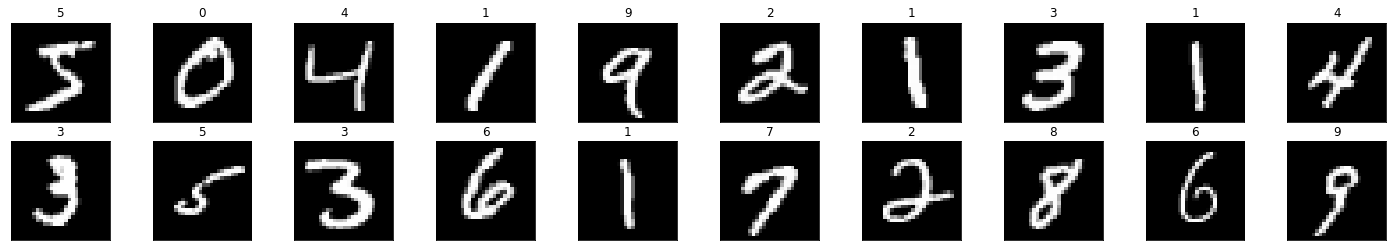

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
images, labels = train_images[:20], train_labels[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    ax.set_title(str(np.argmax(labels[idx])))

### View an Image in More Detail 

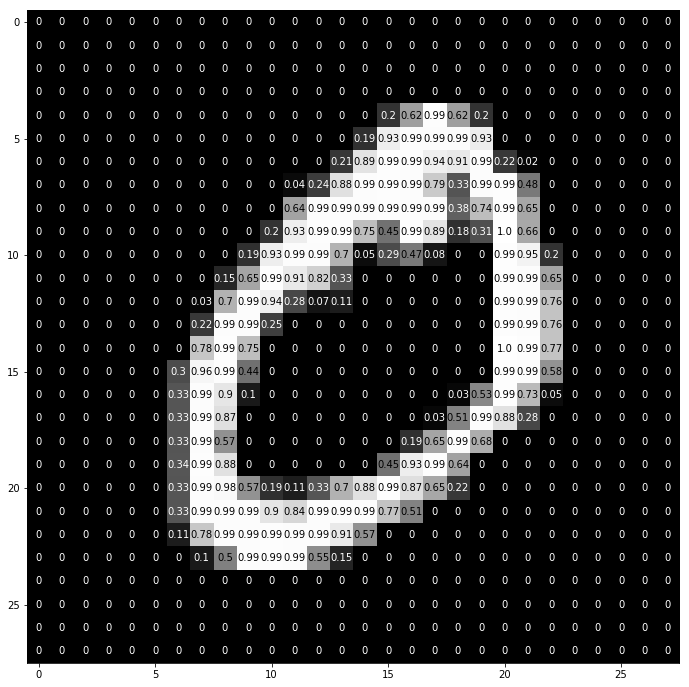

In [6]:
img = np.squeeze(train_images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

The 6 lines of code below show you what a basic convnet looks like. It's a stack of Conv2D and MaxPooling2D layers. We'll see in a minute what they do concretely. Importantly, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In our case, we will configure our convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. We do this via passing the argument input_shape=(28, 28, 1) to our first layer.

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our convnet so far:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape (3, 3, 64)) into a densely-connected classifier network like those you are already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few Dense layers on top:

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576,), before going through two Dense layers.

Now, let's train our convnet on the MNIST digits. 

## Compile and Train

In [11]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


<img src="https://miro.medium.com/max/800/1*vpCRPR2o3tTl6R3JiRcvyQ.png" style="width: 300px;"/>

[src: [https://miro.medium.com/max/800/1*vpCRPR2o3tTl6R3JiRcvyQ.png](https://miro.medium.com/max/800/1*vpCRPR2o3tTl6R3JiRcvyQ.png)]

__Optimizer__: RMSprop (Root Mean Square Prop) and many other optimizers are "*different flavors*" of gradient descent. RMSprop is given by:

\begin{align}
\ S_{dW} &= \beta_{S_{dW}} + (1 - \beta)(\frac{\partial{J}}{\partial{W}})^2\\
\ W &= W - \alpha \frac{\frac{\partial{J}}{\partial{W}}}{\sqrt{S_{dW}}+ \epsilon}\\
\end{align}

where: 

- s  - the exponentially weighted average of past squares of gradients
- $\frac{\partial{J}}{\partial{W}}$ - cost gradient with respect to current layer weight tensor
- W  - weight tensor
- β - hyperparameter to be tuned
- α  - the learning rate
- ϵ - very small value to avoid dividing by zero

__ReLU ( Rectified Linear Unit )__:  $$f(x) = max(0, x)$$


__Some common activation functions__:

<img src='images/activations.png' alt="a few common activation functions" style="width: 500px;">

__Softmax Function__: 

\begin{align}
\ p_i &=  \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}},   \quad  \text{for i = 1, ... , k} 
\end{align}

__Categorical Crossentropy__: Loss function widely used for multiclass classification. It is give by:

\begin{align}
\ L &= - \sum_i y_i \log{p_i}
\end{align}

where $y_i$ is the true class and $p_i$ is the predicted *probability/score* for the true class.

You can read more about Optimizers and Loss Functions [here](http://cs231n.github.io/linear-classify/)

__Training Loop__:

The steps for training/learning from a batch of data are :

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Keras wraps up all of these steps in one function: `model.fit()`. In the following we train for 5 epochs with a batch size of 64. Notice how the loss decreases and accuracy increases as we train.

In [12]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 97us/sample - loss: 0.6058 - accuracy: 0.8397
Epoch 2/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1775 - accuracy: 0.9472
Epoch 3/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1155 - accuracy: 0.9652
Epoch 4/5
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0887 - accuracy: 0.9724
Epoch 5/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0741 - accuracy: 0.9775


## Test the Trained Network

Finally, we test our trained model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Test Accuracy: {:.4f} and Test Loss: {:.4f}'.format(test_acc, test_loss))

Test Accuracy: 0.9793 and Test Loss: 0.0676


In [14]:
# initialize lists to monitor test accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

pred = model.predict(test_images, verbose=0)
pred = np.argmax(pred, axis=-1)
labels = np.argmax(test_labels, axis=-1)

for i in range(len(pred)):
    correct = pred[i] == labels[i]
    class_correct[labels[i]] += correct
    class_total[labels[i]] += 1
    
    
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))  

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 97% (1110/1135)
Test Accuracy of     2: 99% (1022/1032)
Test Accuracy of     3: 97% (989/1010)
Test Accuracy of     4: 96% (943/982)
Test Accuracy of     5: 98% (883/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 95% (984/1028)
Test Accuracy of     8: 98% (962/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 97% (9793/10000)


Lets see predictions on individual test images. Since `model.predict` expects a batch of images, i.e, a 4-d tensor, we expand the first dimension of the test image before feeding into model.

Text(0.5, 1.0, 'Prediction: 7')

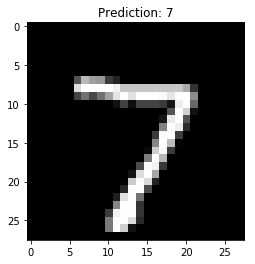

In [15]:
index = 0
pred = model.predict(np.expand_dims(test_images[index], axis=0)); pred = np.argmax(pred)
plt.imshow(np.squeeze(test_images[index]), cmap='gray')
plt.title('Prediction: {}'.format(pred))

In [16]:
#Define a python generator [More on Generators in cifar-10 notebook]
import itertools

def generator(images, labels, batch_size):
    iterable_1 = iter(images)
    iterable_2 = iter(labels)
    while True:
        l1 = tuple(itertools.islice(iterable_1, 0, batch_size))
        l2 = tuple(itertools.islice(iterable_2, 0, batch_size))
        if l1 and l2:
            yield np.vstack(np.expand_dims(l1, axis=0)), np.vstack(np.expand_dims(l2, axis=0))
        else:
            break
            
test_generator = generator(test_images, test_labels, 20)

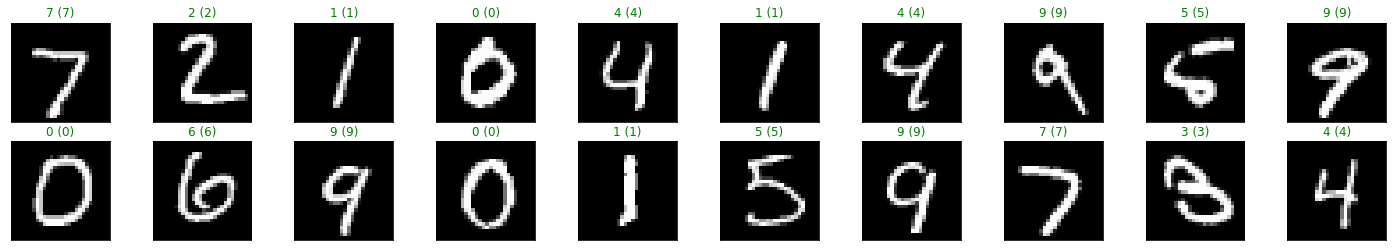

In [17]:
images, labels = next(test_generator)
labels = np.argmax(labels, axis=-1)

# get sample outputs
preds = model.predict(images)
# convert output probabilities to predicted class
preds = np.argmax(preds, axis=-1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

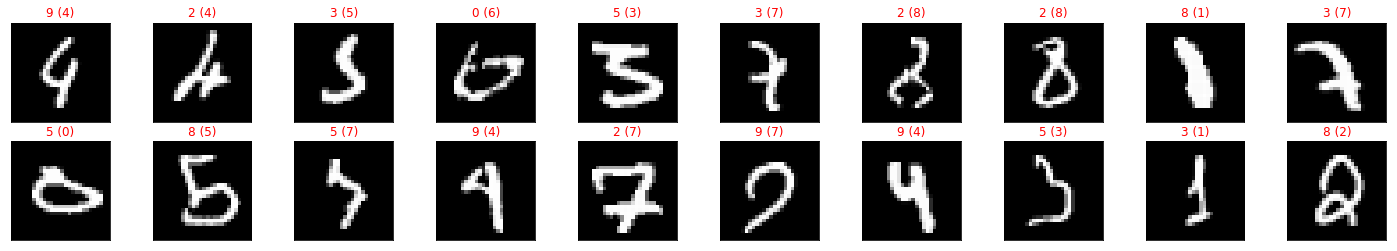

In [18]:
# A sample of Incorrect Predictions
preds = np.argmax(model.predict(test_images), axis=-1)
labels = np.argmax(test_labels, axis=-1)
incorrect_idxs = np.where( preds != labels )[0]

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    idx = incorrect_idxs[i]
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Interpret

### Visualizing second-last-layer Activations

<img src="https://thumbs.gfycat.com/DeadlyDeafeningAtlanticblackgoby-size_restricted.gif" alt="Second Last Layer Activations" style="width: 400px;"/> (src: 3blue1brown)

In [19]:
from tensorflow.keras import Model

emb_model = Model(inputs = model.input, outputs = model.get_layer('dense').output)

In [20]:
emb_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0     

In [21]:
activations = emb_model.predict(test_images, verbose=1)
predictions = model.predict(test_images, verbose=1); labels = predictions.argmax(axis=-1)

10000/10000 [==============================] - 0s 38us/sample


In [22]:
activations.shape

(10000, 64)

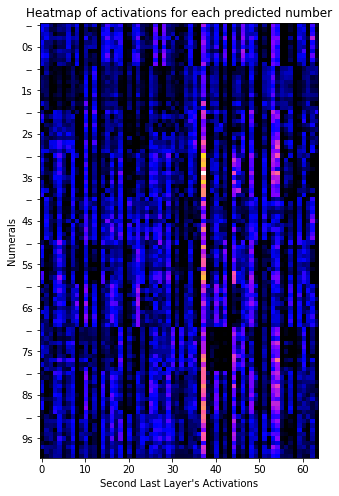

In [23]:
# Stack 10 examples of activation vectors for each numeral
seq = []
for i in range(10):
    seq.append(activations[labels==i][:10])
seq = np.vstack(seq)


# Plot heatmap for the example activations
plt.figure(figsize=(8,8))
plt.imshow(seq, interpolation='nearest', cmap=plt.cm.gnuplot2)
plt.yticks(np.arange(0,100, 5), ['--','0s','--','1s','--','2s','--','3s','--','4s','--','5s','--','6s',
                                 '--','7s','--','8s','--','9s'])
plt.xlabel("Second Last Layer's Activations")
plt.ylabel('Numerals')
plt.title('Heatmap of activations for each predicted number')
plt.show()

#### Tensorboard

In [24]:
import io

with io.open('vecs.tsv', 'w', encoding='utf-8') as out_v:
    for embed in activations:
        out_v.write('\t'.join([str(x) for x in embed]) + "\n")
        
with io.open('meta.tsv', 'w', encoding='utf-8') as out_m:
    for l in labels:
        out_m.write(str(l) + "\n")

Now go to: https://projector.tensorflow.org/, in the data section click `Load`, and upload the two files: _vecs.tsv_ and _meta.tsv_

#### tSNE 

<img src="images/tSNE.png" alt="tSNE" style="width: 400px;"/> 

### Visualizing intermediate-layer activations

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

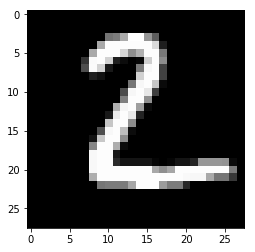

In [26]:
img = test_images[1]
img = np.expand_dims(img, axis=0)

plt.imshow(np.squeeze(img), cmap='gray')

In [27]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [28]:
# This will return a list of 8 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img)

In [29]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 26, 26, 32)


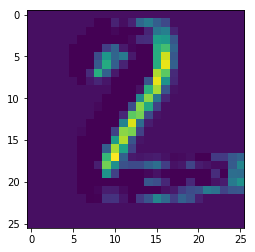

In [30]:
plt.imshow(first_layer_activation[0, :, :, 6], cmap='viridis')
plt.show()

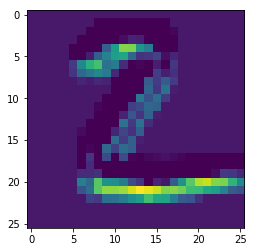

In [31]:
plt.imshow(first_layer_activation[0, :, :, 12], cmap='viridis')
plt.show()

/opt/apps/anaconda3/envs/wmlce-v1.7.0-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


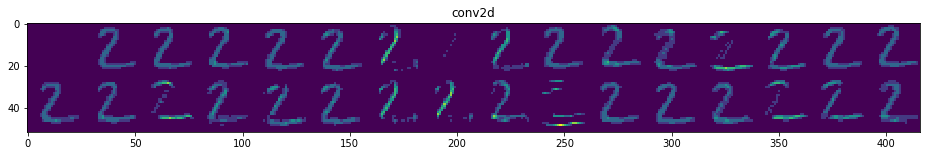

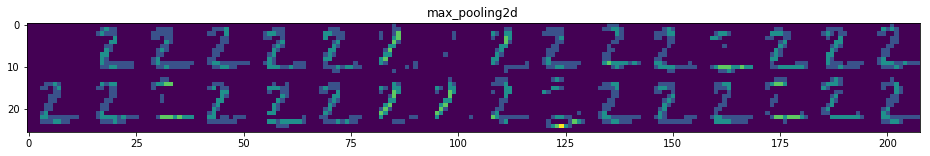

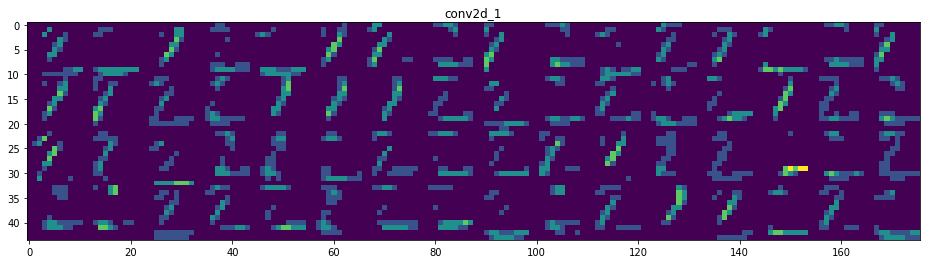

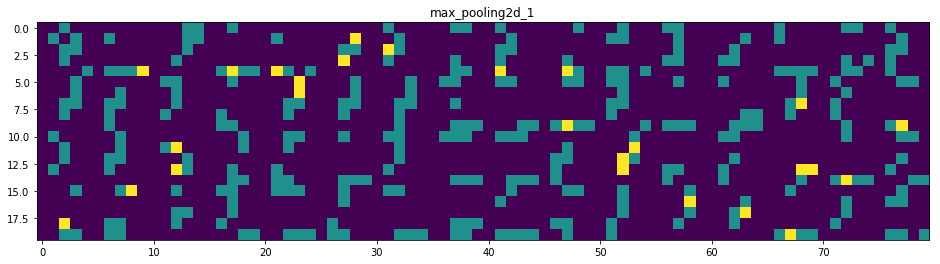

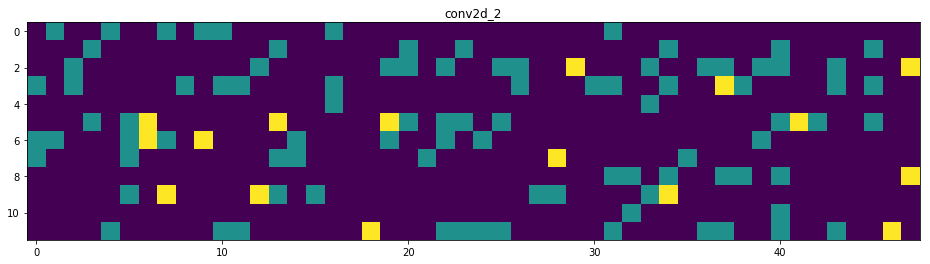

In [32]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Also see: [Visualizing and Understanding Convolutional Networks, Zeiler et. al.](https://arxiv.org/pdf/1311.2901.pdf)

### Visualizing heatmap of class activation 

To visualize which parts of our image were the most "prediction"-like, let's set up the Grad-CAM process.

"Class Activation Map" (CAM) is a visualization technique which is useful for understanding which parts of a given image led a convnet to its final classification decision, by producing heatmaps of "class activation" over input images.

You can read more about this technique here: [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization.](https://arxiv.org/abs/1610.02391)

<img src="https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png" alt="MNIST CNN" style="width: 600px;"/> 

[src: [https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png](https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png)]

In [33]:
import tensorflow.keras.backend as K
import cv2

In [34]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [35]:
def get_superimposed_img(img, heatmap):
    im = np.array(np.squeeze(img) * 255, dtype = np.uint8)
    cv2.imwrite('test_img.jpg', im)

    # We use cv2 to load the original image
    img = cv2.imread('test_img.jpg', 0)

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # 0.9 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.9 + img

    # Save the image to disk
    cv2.imwrite('test_img_cam.jpg', superimposed_img)
    
    cam = cv2.imread('test_img_cam.jpg', 0)
    return cam, heatmap

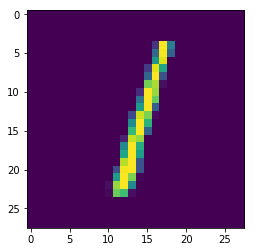

In [36]:
img = test_images[2]
img = np.expand_dims(img, axis=0)
plt.imshow(np.squeeze(img))

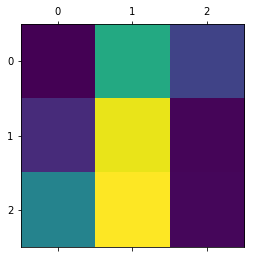

In [37]:
last_conv_layer_name = "conv2d_2" 

# Remove last layer's softmax
model.layers[-1].activation = None

# What the top predicted class is
preds = model.predict(img)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [38]:
cam, heatmap = get_superimposed_img(img, heatmap)

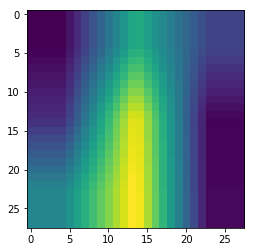

In [39]:
plt.imshow(heatmap)

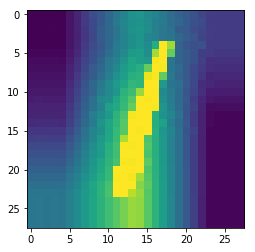

In [40]:
plt.imshow(cam)

In [41]:
cams, heatmaps = [], []

for i in range(280,291):
    
    img = test_images[i]
    img = np.expand_dims(img, axis=0)
    
    preds = model.predict(img)
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
        
    cam, heatmap = get_superimposed_img(img, heatmap)
    
    cams.append(cam)
    heatmaps.append(heatmap)

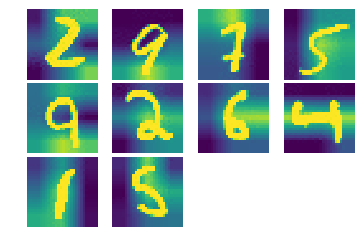

In [42]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.axis('Off')
    plt.subplots_adjust(wspace=0.1,hspace=0.05)
    plt.imshow(cams[i])

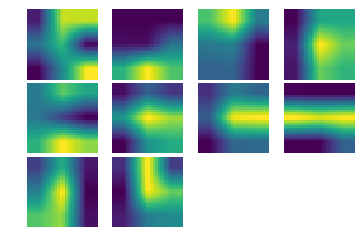

In [43]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.axis('Off')
    plt.subplots_adjust(wspace=0.1,hspace=0.05)
    plt.imshow(heatmaps[i])